In [37]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from functools import reduce
from datetime import datetime

In [38]:
df = pd.read_csv('brazil_covid19.csv')
df = df.set_index('date')
df.head()

,region,state,cases,deaths
date,,,,
2020-01-30,Centro-Oeste,Distrito Federal,0,0
2020-01-30,Centro-Oeste,Goiás,0,0
2020-01-30,Centro-Oeste,Mato Grosso,0,0
2020-01-30,Centro-Oeste,Mato Grosso do Sul,0,0
2020-01-30,Nordeste,Alagoas,0,0


In [39]:
estados = [df.query('state == "%s" and cases != 0'%state) for state in df.state.unique()]
estados_tratado = []
for estado in estados:
    nome_estado = estado['state'][0].lower().replace(' ', '_')
    nome_coluna = 'dias_corridos_%s' % nome_estado
    estado[nome_coluna] = range(1, len(estado) + 1)
    estados_tratado += [estado[[nome_coluna]] ]   
estados_tratado = sorted(estados_tratado, key=len, reverse=True)


df_tratado = reduce(lambda x1, x2: x1.join(x2), estados_tratado).fillna(0)
df_tratado.index = df_tratado.index.map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

soma_casos = df.groupby('date')[['cases']].sum().sort_values('date')
soma_mortes = df.groupby('date')[['deaths']].sum().sort_values('date')
df_tratado['dias_corridos_total'] = range(1, len(df_tratado)+1)

C:\Users\jp-ad\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
#def get_polinomial_features(degree=3):
def get_poly_features(df_tratado, degree=3):
    df_tratado = df_tratado.copy()
    columns_poly = []
    
    for column in df_tratado.columns:
        if column in ['cases', 'deaths']:
            continue
        pf = PolynomialFeatures(degree=degree)
        column_poly = pf.fit_transform(df_tratado[column].values.reshape(-1,1))
        column_poly = column_poly[:,1:]

        columns_degree = ['{}^{}'.format(column, i) for i in range(1, degree+1)]
        column_poly = pd.DataFrame(column_poly, columns=columns_degree, index=df_tratado.index)
        
        columns_poly += [column_poly]
    novo_df_tratado = pd.concat(columns_poly, axis=1)
    novo_df_tratado = novo_df_tratado.join(soma_casos).join(soma_mortes)
    return novo_df_tratado


In [41]:
treino = df_tratado.loc[:'2020-03-31']
teste = df_tratado.loc['2020-04-01':]

treino_casos = get_poly_features(treino, 3)
teste_casos = get_poly_features(teste, 3)


In [42]:
x_treino_casos, y_treino_casos, = treino_casos.iloc[:, :-2], treino_casos.loc[:,['cases']]
x_teste_casos, y_teste_casos = teste_casos.iloc[:, :-2], teste_casos.loc[:,['cases']]


## Modelo para casos

In [43]:
lr_casos = LinearRegression()
lr_casos.fit(x_treino_casos, y_treino_casos)
y_pred_casos = lr_casos.predict(  x_teste_casos)
score_casos = r2_score(y_teste_casos, y_pred_casos)
print(f'{score_casos:.2%}')


93.95%


## Plot dos casos

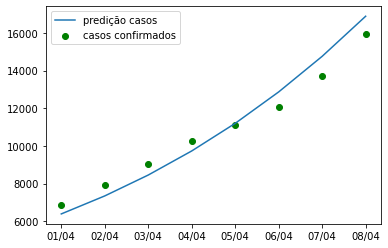

In [44]:
import matplotlib.pyplot as plt
axis_x = y_teste_casos.index.map(lambda x: x.strftime('%d/%m'))
plt.plot(y_pred_casos)
plt.scatter(x=axis_x, y = y_teste_casos, color='green')

plt.legend(['predição casos','casos confirmados'])

In [45]:
x_casos = pd.concat([x_treino_casos, x_teste_casos]).sort_values('date')
y_casos = pd.concat([y_treino_casos, y_teste_casos]).sort_values('date')
y_pred_casos_completo = lr_casos.predict(x_casos)

df_tratado_mortes = get_poly_features(df_tratado, degree=3)
df_tratado_mortes['cases'] = y_pred_casos_completo.round(0)
df_tratado_mortes.tail()

,dias_corridos_são_paulo^1,dias_corridos_são_paulo^2,dias_corridos_são_paulo^3,dias_corridos_rio_de_janeiro^1,dias_corridos_rio_de_janeiro^2,dias_corridos_rio_de_janeiro^3,dias_corridos_bahia^1,dias_corridos_bahia^2,dias_corridos_bahia^3,dias_corridos_espírito_santo^1,...,dias_corridos_maranhão^2,dias_corridos_maranhão^3,dias_corridos_roraima^1,dias_corridos_roraima^2,dias_corridos_roraima^3,dias_corridos_total^1,dias_corridos_total^2,dias_corridos_total^3,cases,deaths
date,,,,,,,,,,,,,,,,,,,,,
2020-04-04,39.0,1521.0,59319.0,31.0,961.0,29791.0,30.0,900.0,27000.0,30.0,...,225.0,3375.0,14.0,196.0,2744.0,39.0,1521.0,59319.0,9733.0,432
2020-04-05,40.0,1600.0,64000.0,32.0,1024.0,32768.0,31.0,961.0,29791.0,31.0,...,256.0,4096.0,15.0,225.0,3375.0,40.0,1600.0,64000.0,11199.0,486
2020-04-06,41.0,1681.0,68921.0,33.0,1089.0,35937.0,32.0,1024.0,32768.0,32.0,...,289.0,4913.0,16.0,256.0,4096.0,41.0,1681.0,68921.0,12869.0,553
2020-04-07,42.0,1764.0,74088.0,34.0,1156.0,39304.0,33.0,1089.0,35937.0,33.0,...,324.0,5832.0,17.0,289.0,4913.0,42.0,1764.0,74088.0,14760.0,667
2020-04-08,43.0,1849.0,79507.0,35.0,1225.0,42875.0,34.0,1156.0,39304.0,34.0,...,361.0,6859.0,18.0,324.0,5832.0,43.0,1849.0,79507.0,16889.0,800


In [46]:
treino_mortes = df_tratado_mortes.loc[:'2020-03-31']
teste_mortes = df_tratado_mortes.loc['2020-04-01':]


x_treino_mortes, y_treino_mortes = treino_mortes.iloc[:, :-2] , treino_mortes.loc[:,['deaths']]
x_teste_mortes, y_teste_mortes = teste_mortes.iloc[:, :-2] , teste_mortes.loc[:,['deaths']]

In [264]:
lr_mortes = LinearRegression()
lr_mortes.fit(x_treino_mortes, y_treino_mortes)
y_pred_mortes = lr_mortes.predict(x_teste_mortes)
score_mortes = r2_score(y_teste_mortes, y_pred_mortes)
print(f'Taxa de acerto: {score_mortes:.2%}')


Taxa de acerto: 88.70%


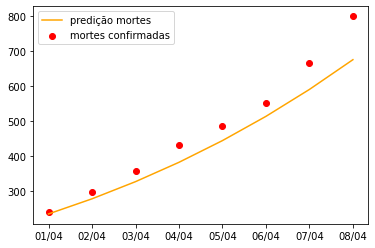

In [48]:
y_teste_mortes.index=axis_x
plt.plot(y_pred_mortes, color='orange')
plt.scatter(x=axis_x, y=y_teste_mortes, color='red')
plt.legend(['predição mortes', 'mortes confirmadas'])
plt.show()

## Previsões até o final de Abril

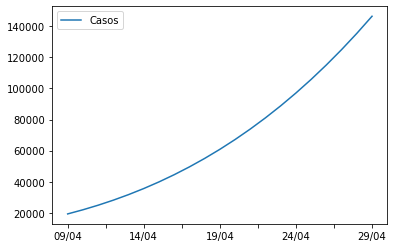

In [265]:
from datetime import timedelta
qtd_dias_prever=21
dias = []
for i in range(1, qtd_dias_prever+1):
    dia_previsto = pd.DataFrame(df_tratado.iloc[-1] + i).transpose()
    dia_previsto.index = dia_previsto.index + timedelta(i)
    dias += [dia_previsto]

#dias = pd.concat(dias)
dias_previsto = get_poly_features(pd.concat(dias)).iloc[:, :-2]
dias_plot = dias_previsto.index.map(lambda x: x.strftime('%d/%m'))
pred_casos = pd.DataFrame(lr_casos.predict(dias_previsto), index=dias_plot)
pred_casos.columns = ['Casos']
pred_casos.plot()


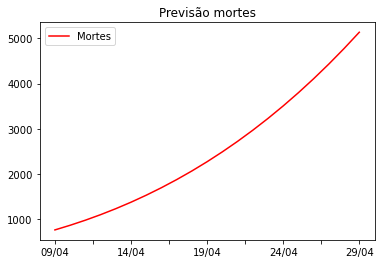

In [266]:
pred_mortes = lr_mortes.predict(dias_previsto)
pred_mortes = pd.DataFrame(pred_mortes, index=dias_plot)
pred_mortes.columns=['Mortes']
pred_mortes.plot(title='Previsão mortes', legend=['Mortes'], color='red')